# Movie Poster Text Attention Classification
## 1. Melvin Waluyo (22/492978/TK/53972)
## 2. Alexander Johan Pramudito (22/492990/TK/53976)
## 3. Muhammad Grandiv Lava Putra (22/493242/TK/54023)

Implementasi pendekatan deep learning dengan pre-trained model ResNet50 yang di-transfer learning untuk klasifikasi level atensi dari teks pada poster film. Skala yang digunakan adalah 0 (tidak menarik) hingga 4 (sangat menarik).

### Lakukan Import Dataset ke Environment Local

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Cell 1: Setup local dataset paths
def setup_local_dataset():
    """Set up paths for local dataset files"""
    # Define the local dataset paths
    images_path = 'datasets'
    csv_path = 'attention.csv'

    # Check if the paths exist
    if not os.path.exists(images_path):
        print(f"Warning: Image directory '{images_path}' not found!")
    else:
        print(f"Found images directory at '{images_path}'")

    if not os.path.exists(csv_path):
        print(f"Warning: CSV file '{csv_path}' not found!")
    else:
        print(f"Found attention.csv file at '{csv_path}'")

    return images_path, csv_path


Found images directory at 'datasets'
Found attention.csv file at 'attention.csv'
Loading attention.csv...
Dataset loaded successfully!
Total samples: 300
attention
0     29
1     56
2     55
3     47
4    113
Name: count, dtype: int64

Preview of attention.csv:


,image,attention
0,1,1
1,2,2
2,3,1
3,4,4
4,5,1



Missing values in the dataset:
image        0
attention    0
dtype: int64

Class distribution (attention levels):
attention
0     29
1     56
2     55
3     47
4    113
Name: count, dtype: int64


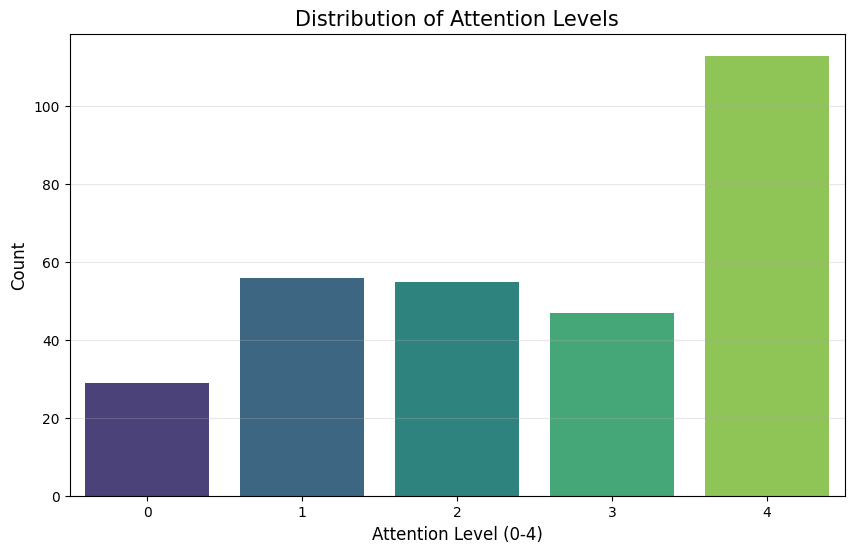


Checking image availability...
Found 300 image files


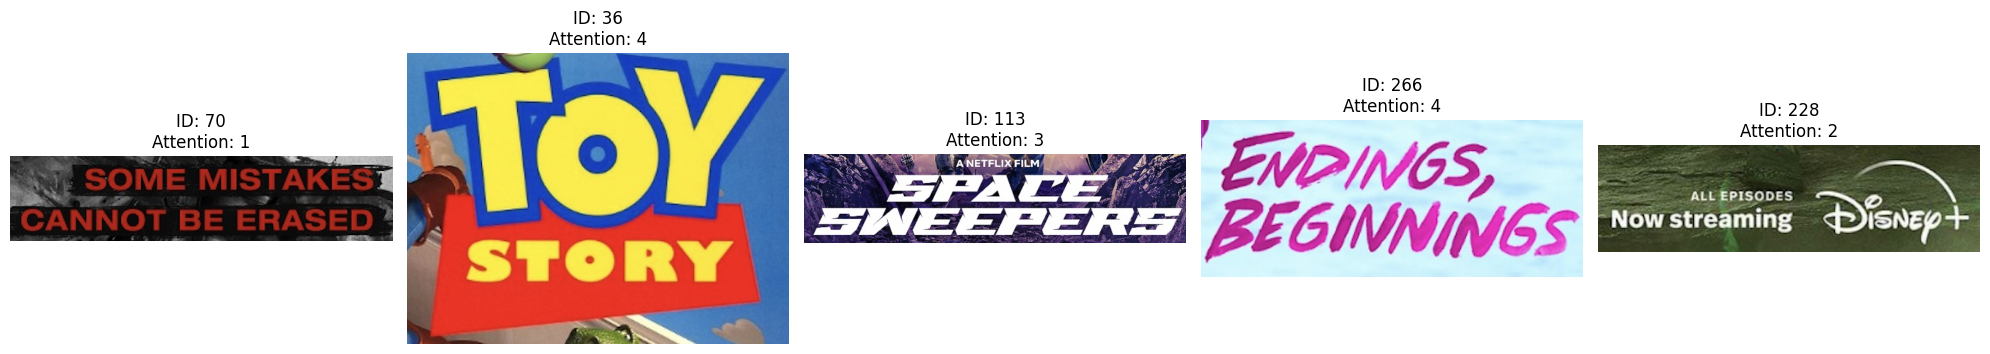


Analyzing image dimensions...
Width range: 114 to 1036
Height range: 52 to 550
Aspect ratio range: 1.20 to 8.36


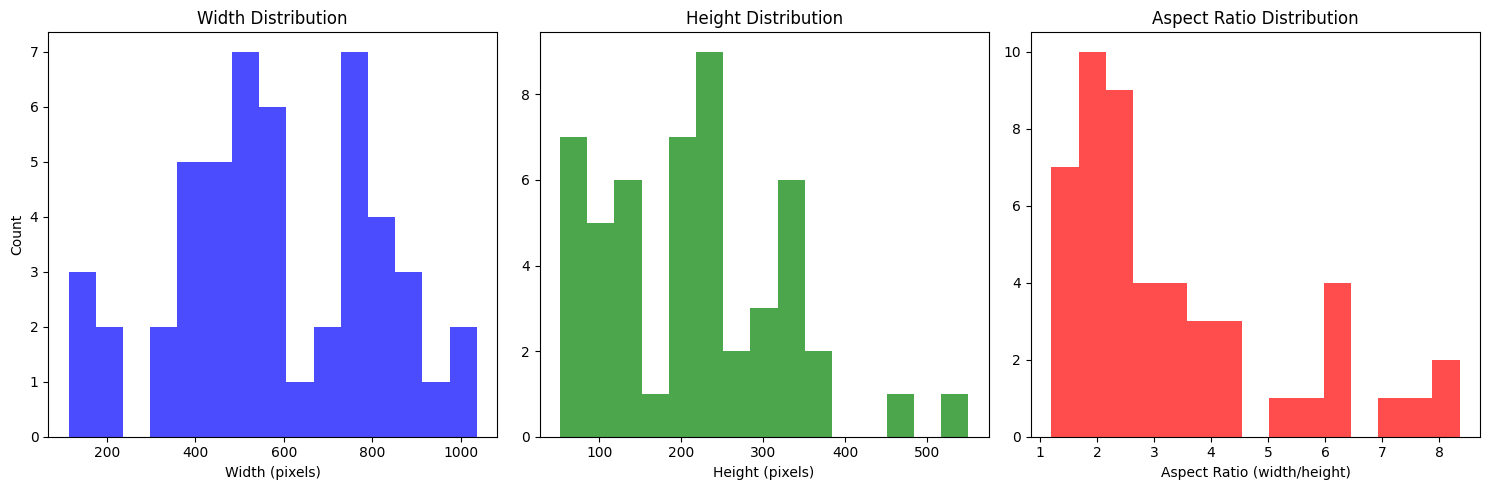

In [ ]:
# Cell 2: Load and explore the dataset
def load_and_explore_data(images_path, csv_path):
    """Load the dataset and perform exploratory data analysis"""
    # Load the attention.csv file
    print("Loading attention.csv...")

    # Load from local path
    attention_df = pd.read_csv(csv_path, header=None)
    attention_df.columns = ['image', 'attention']

    # Extract the numeric part from image filenames for proper sorting
    attention_df['image'] = attention_df['image'].str.replace('.png', '', regex=False)

    print("Dataset loaded successfully!")
    print(f"Total samples: {len(attention_df)}")

    attention_df['attention'] = attention_df['attention'].clip(upper=4)
    # Verifikasi distribusi
    print(attention_df['attention'].value_counts().sort_index())

    # Display the first few rows of the dataset
    print("\nPreview of attention.csv:")
    display(attention_df.head())

    # Check for missing values
    print("\nMissing values in the dataset:")
    print(attention_df.isnull().sum())

    # Explore class distribution
    print("\nClass distribution (attention levels):")
    class_distribution = attention_df['attention'].value_counts().sort_index()
    print(class_distribution)

    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x='attention', data=attention_df, palette='viridis')
    plt.title('Distribution of Attention Levels', fontsize=15)
    plt.xlabel('Attention Level (0-4)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # Check image availability
    print("\nChecking image availability...")
    # Check in local path
    image_files = [f for f in os.listdir(images_path) if f.endswith('.png')]

    print(f"Found {len(image_files)} image files")

    # Visualize a few sample images with their attention levels
    plt.figure(figsize=(20, 12))
    samples_to_show = min(5, len(image_files))

    for i in range(samples_to_show):
        try:
            img_name = image_files[i]
            img_id = img_name.split('.')[0]  # Get the filename without extension
            attention_level = attention_df.loc[attention_df['image'] == img_id, 'attention'].values[0]

            img_path = os.path.join(images_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(1, samples_to_show, i+1)
            plt.imshow(img)
            plt.title(f"ID: {img_id}\nAttention: {attention_level}", fontsize=12)
            plt.axis('off')
        except Exception as e:
            print(f"Error displaying image {i}: {e}")

    plt.tight_layout()
    plt.show()

    # Check image dimensions
    print("\nAnalyzing image dimensions...")
    width_list = []
    height_list = []
    aspect_ratios = []

    for img_name in image_files[:min(50, len(image_files))]:  # Sample first 50 images
        try:
            img_path = os.path.join(images_path, img_name)
            img = Image.open(img_path)
            width, height = img.size
            width_list.append(width)
            height_list.append(height)
            aspect_ratios.append(width/height)
        except Exception as e:
            print(f"Error processing {img_name}: {e}")

    print(f"Width range: {min(width_list)} to {max(width_list)}")
    print(f"Height range: {min(height_list)} to {max(height_list)}")
    print(f"Aspect ratio range: {min(aspect_ratios):.2f} to {max(aspect_ratios):.2f}")

    # Visualize image dimensions
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(width_list, bins=15, alpha=0.7, color='blue')
    plt.title('Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Count')

    plt.subplot(1, 3, 2)
    plt.hist(height_list, bins=15, alpha=0.7, color='green')
    plt.title('Height Distribution')
    plt.xlabel('Height (pixels)')

    plt.subplot(1, 3, 3)
    plt.hist(aspect_ratios, bins=15, alpha=0.7, color='red')
    plt.title('Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (width/height)')

    plt.tight_layout()
    plt.show()

    return attention_df, images_path

# Execute the cells

images_path, csv_path = setup_local_dataset()
attention_df, images_path = load_and_explore_data(images_path, csv_path)

In [ ]:
# Cell 3: Preprocess images and prepare dataset
def preprocess_images(attention_df, images_path, target_size=(224, 224)):
    """
    Preprocess images and prepare the dataset for training

    Args:
        attention_df: DataFrame containing image IDs and attention levels
        images_path: Path to the folder containing images
        target_size: Target size for resizing images

    Returns:
        X: Preprocessed images
        y: Attention levels (labels)
        image_ids: List of image IDs
    """
    print("Preprocessing images...")

    X = []  # For storing preprocessed images
    y = []  # For storing attention levels
    image_ids = []  # For storing image IDs
    failed_images = []  # To keep track of images that couldn't be processed

    for index, row in attention_df.iterrows():
        img_id = row['image']
        attention_level = row['attention']

        # Construct the image file path
        img_path = os.path.join(images_path, f"{img_id}.png")

        try:
            # Load and preprocess image
            img = cv2.imread(img_path)

            # Skip if image not found
            if img is None:
                failed_images.append(img_id)
                continue

            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize image while preserving aspect ratio
            h, w = img.shape[:2]
            aspect_ratio = w / h

            if aspect_ratio > 1:  # Wider than tall
                new_w = target_size[0]
                new_h = int(new_w / aspect_ratio)
                if new_h == 0:
                    new_h = 1  # Ensure height is at least 1 pixel
            else:  # Taller than wide or square
                new_h = target_size[1]
                new_w = int(new_h * aspect_ratio)
                if new_w == 0:
                    new_w = 1  # Ensure width is at least 1 pixel

            # Resize while preserving aspect ratio
            resized_img = cv2.resize(img, (new_w, new_h))

            # Create black canvas of target size
            canvas = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

            # Calculate position to paste the resized image (center)
            x_offset = (target_size[0] - new_w) // 2
            y_offset = (target_size[1] - new_h) // 2

            # Paste the resized image onto the canvas
            canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_img

            # Normalize pixel values to [0, 1]
            canvas = canvas.astype(np.float32) / 255.0

            # Add to dataset
            X.append(canvas)
            y.append(attention_level)
            image_ids.append(img_id)

        except Exception as e:
            print(f"Error processing image {img_id}: {e}")
            failed_images.append(img_id)

    print(f"Successfully processed {len(X)} images")
    print(f"Failed to process {len(failed_images)} images")

    if failed_images:
        print(f"Failed image IDs: {failed_images}")

    return np.array(X), np.array(y), image_ids


In [ ]:
# Cell 4: Extract additional features from images
def extract_additional_features(X, image_ids):
    """
    Extract additional features from images to improve classification

    Args:
        X: Array of preprocessed images
        image_ids: List of image IDs

    Returns:
        additional_features: Array of additional features
    """
    print("Extracting additional features...")

    additional_features = []

    for i, img in enumerate(X):
        # Convert back to uint8 for OpenCV functions
        img_uint8 = (img * 255).astype(np.uint8)

        # Extract color features
        hsv_img = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)

        # Compute color histograms
        h_hist = cv2.calcHist([hsv_img], [0], None, [10], [0, 180])
        s_hist = cv2.calcHist([hsv_img], [1], None, [10], [0, 256])
        v_hist = cv2.calcHist([hsv_img], [2], None, [10], [0, 256])

        # Normalize histograms
        h_hist = cv2.normalize(h_hist, h_hist).flatten()
        s_hist = cv2.normalize(s_hist, s_hist).flatten()
        v_hist = cv2.normalize(v_hist, v_hist).flatten()

        # Calculate the average saturation and value (brightness)
        avg_saturation = np.mean(hsv_img[:, :, 1])
        avg_brightness = np.mean(hsv_img[:, :, 2])

        # Calculate color variance (contrast)
        color_variance = np.std(img_uint8)

        # Extract edges using Canny edge detector
        edges = cv2.Canny(img_uint8, 100, 200)
        edge_density = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])

        # Extract text regions using MSER
        # Convert to grayscale
        gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)

        try:
            # Apply MSER to detect text regions
            mser = cv2.MSER_create()
            regions, _ = mser.detectRegions(gray)

            # Calculate text region features
            if regions:
                total_text_area = sum(cv2.contourArea(np.array(region).reshape(-1, 1, 2)) for region in regions)
                text_area_ratio = total_text_area / (img.shape[0] * img.shape[1])
                num_text_regions = len(regions)
            else:
                text_area_ratio = 0
                num_text_regions = 0
        except:
            text_area_ratio = 0
            num_text_regions = 0

        # Combine all features
        features = np.concatenate([
            h_hist,
            s_hist,
            v_hist,
            [avg_saturation,
             avg_brightness,
             color_variance,
             edge_density,
             text_area_ratio,
             num_text_regions]
        ])

        additional_features.append(features)

    additional_features = np.array(additional_features)
    print(f"Extracted {additional_features.shape[1]} additional features")

    return additional_features

# Execute the cells
X, y, image_ids = preprocess_images(attention_df, images_path)
additional_features = extract_additional_features(X, image_ids)



Preprocessing images...
Successfully processed 300 images
Failed to process 0 images
Extracting additional features...
Extracted 36 additional features


In [ ]:
# Cell 5: Split the dataset and handle class imbalance
def prepare_train_test_data(X, y, additional_features, test_size=0.2, random_state=42):
    """
    Split the dataset into training and testing sets and handle class imbalance

    Args:
        X: Array of preprocessed images
        y: Array of attention levels
        additional_features: Array of additional features
        test_size: Proportion of the dataset to include in the test split
        random_state: Random seed for reproducibility

    Returns:
        X_train, X_test: Training and testing image data
        y_train, y_test: Training and testing labels
        additional_features_train, additional_features_test: Training and testing additional features
        class_weights: Weights for handling class imbalance
    """
    print("Preparing training and testing datasets...")

    # Check class distribution
    class_counts = np.bincount(y.astype(int))
    print(f"Class distribution: {class_counts}")

    # Convert labels to categorical
    y_categorical = to_categorical(y)

    # Split the dataset - check if we can use stratified split
    if np.min(class_counts) >= 2:
        print("Using stratified split to maintain class distribution")
        X_train, X_test, y_train, y_test, additional_features_train, additional_features_test, indices_train, indices_test = train_test_split(
            X, y_categorical, additional_features, np.arange(len(y)),
            test_size=test_size,
            random_state=random_state,
            stratify=y  # Ensure class distribution is preserved
        )
    else:
        print("WARNING: Some classes have only one sample. Using random split instead of stratified.")
        X_train, X_test, y_train, y_test, additional_features_train, additional_features_test, indices_train, indices_test = train_test_split(
            X, y_categorical, additional_features, np.arange(len(y)),
            test_size=test_size,
            random_state=random_state
            # No stratify parameter
        )

    # Get original class labels for computing class weights
    y_train_orig = np.argmax(y_train, axis=1)

    # Compute class weights to handle imbalance
    unique_classes = np.unique(y_train_orig)
    # Some classes might be missing in training set after splitting
    # Use only classes that are present
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=y_train_orig
    )
    class_weight_dict = {unique_classes[i]: class_weights[i] for i in range(len(class_weights))}

    # Ensure all classes from 0 to num_classes-1 have weights
    num_classes = len(np.unique(y))
    for i in range(num_classes):
        if i not in class_weight_dict:
            class_weight_dict[i] = 1.0  # Default weight for missing classes

    print("Dataset split complete.")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")

    print("\nClass weights for handling imbalance:")
    for cls, weight in sorted(class_weight_dict.items()):
        print(f"Class {cls}: {weight:.4f}")

    return X_train, X_test, y_train, y_test, additional_features_train, additional_features_test, class_weight_dict


In [ ]:
# Cell 6: Build and train the model
def build_attention_model(input_shape=(224, 224, 3), additional_features_shape=None, num_classes=5):
    """
    Build a combined CNN model using transfer learning and additional features

    Args:
        input_shape: Shape of the input images
        additional_features_shape: Shape of the additional features
        num_classes: Number of attention levels (classes)

    Returns:
        model: Compiled Keras model
    """
    print("Building the model...")

    # Base model with ResNet50 pretrained on ImageNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Image feature extraction
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # If we have additional features, create a separate input for them
    if additional_features_shape is not None:
        additional_input = tf.keras.Input(shape=(additional_features_shape,))
        additional_x = Dense(64, activation='relu')(additional_input)
        additional_x = BatchNormalization()(additional_x)
        additional_x = Dropout(0.3)(additional_x)

        # Combine the CNN features with additional features
        combined = tf.keras.layers.concatenate([x, additional_x])

        # Final dense layers
        x = Dense(256, activation='relu')(combined)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        predictions = Dense(num_classes, activation='softmax')(x)

        # Create the combined model
        model = Model(inputs=[base_model.input, additional_input], outputs=predictions)
    else:
        # If no additional features, use only the CNN
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        predictions = Dense(num_classes, activation='softmax')(x)

        # Create the CNN-only model
        model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("Model built successfully!")
    model.summary()

    return model



In [ ]:
# Cell 7: Train the model with data augmentation
def train_model(model, X_train, y_train, X_test, y_test,
                additional_features_train=None, additional_features_test=None,
                class_weight_dict=None, epochs=30, batch_size=16):
    """
    Train the model with data augmentation

    Args:
        model: Compiled Keras model
        X_train, y_train: Training data and labels
        X_test, y_test: Testing data and labels
        additional_features_train, additional_features_test: Additional features for training and testing
        class_weight_dict: Class weights for handling imbalance
        epochs: Number of epochs for training
        batch_size: Batch size for training

    Returns:
        history: Training history
        model: Trained model
    """
    print("Training the model with data augmentation...")

    # Set up callbacks
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
        ModelCheckpoint('best_attention_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    # For model with additional features, we need a custom training approach
    if additional_features_train is not None and additional_features_test is not None:
        print("Training with combined image features and additional features...")

        # Create a custom training loop using tf.data.Dataset
        # This avoids issues with the Keras Sequence interface

        # Parameters for data augmentation
        aug_params = {
            'rotation_range': 15,
            'width_shift_range': 0.15,
            'height_shift_range': 0.15,
            'shear_range': 0.15,
            'zoom_range': 0.2,
            'horizontal_flip': True,
            'brightness_range': [0.8, 1.2]
        }

        # Custom function to augment a single image
        def augment_image(image):
            image = image.numpy()
            datagen = ImageDataGenerator(**aug_params)
            img_aug = datagen.random_transform(image)
            return img_aug

        # Vectorize the augmentation function for tf.data
        def augment_batch(images):
            augmented = tf.py_function(
                lambda x: np.array([augment_image(img) for img in x]),
                [images],
                tf.float32
            )
            augmented.set_shape(images.shape)
            return augmented

        # Create datasets directly without generators
        # Convert to NumPy arrays for direct manual batch processing
        X_train_np = np.array(X_train)
        y_train_np = np.array(y_train)
        additional_features_train_np = np.array(additional_features_train)

        X_test_np = np.array(X_test)
        y_test_np = np.array(y_test)
        additional_features_test_np = np.array(additional_features_test)

        # Calculate sample weights from class weights
        y_train_indices = np.argmax(y_train_np, axis=1)
        sample_weights = np.ones(len(y_train_indices))
        for i, idx in enumerate(y_train_indices):
            if idx in class_weight_dict:
                sample_weights[i] = class_weight_dict[idx]

        # History storage for manual training
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        # Manual training loop
        best_val_accuracy = 0
        patience_counter = 0
        best_weights = None

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            # Shuffle training data for this epoch
            indices = np.random.permutation(len(X_train_np))
            X_train_shuffled = X_train_np[indices]
            y_train_shuffled = y_train_np[indices]
            additional_features_train_shuffled = additional_features_train_np[indices]
            sample_weights_shuffled = sample_weights[indices]

            # Training
            epoch_loss = 0
            epoch_accuracy = 0
            steps = 0

            for i in range(0, len(X_train_shuffled), batch_size):
                # Get batch
                end_idx = min(i + batch_size, len(X_train_shuffled))
                X_batch = X_train_shuffled[i:end_idx]
                y_batch = y_train_shuffled[i:end_idx]
                features_batch = additional_features_train_shuffled[i:end_idx]
                weights_batch = sample_weights_shuffled[i:end_idx]

                # Augment images in this batch
                X_batch_aug = np.zeros_like(X_batch)
                datagen = ImageDataGenerator(**aug_params)
                for j in range(len(X_batch)):
                    X_batch_aug[j] = datagen.random_transform(X_batch[j])

                # Train on this batch
                batch_loss, batch_accuracy = model.train_on_batch(
                    [X_batch_aug, features_batch],
                    y_batch,
                    sample_weight=weights_batch
                )

                # Update progress
                steps += 1
                epoch_loss += batch_loss
                epoch_accuracy += batch_accuracy

                # Print progress
                if steps % 5 == 0 or end_idx == len(X_train_shuffled):
                    print(f"Step {steps}/{len(X_train_shuffled)//batch_size + (1 if len(X_train_shuffled) % batch_size > 0 else 0)} - "
                          f"loss: {batch_loss:.4f} - accuracy: {batch_accuracy:.4f}", end='\r')

            # Calculate average metrics for the epoch
            epoch_loss /= steps
            epoch_accuracy /= steps

            # Validation
            val_loss, val_accuracy = model.evaluate(
                [X_test_np, additional_features_test_np],
                y_test_np,
                verbose=0
            )

            # Store history
            history['loss'].append(epoch_loss)
            history['accuracy'].append(epoch_accuracy)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)

            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{epochs} - loss: {epoch_loss:.4f} - accuracy: {epoch_accuracy:.4f} - "
                  f"val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

            # Check for improvement (for early stopping)
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                patience_counter = 0
                # Save best weights
                best_weights = model.get_weights()
                print(f"New best validation accuracy: {best_val_accuracy:.4f}")
            else:
                patience_counter += 1
                print(f"No improvement. Patience: {patience_counter}/{callbacks[0].patience}")

            # Early stopping
            if patience_counter >= callbacks[0].patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        # Restore best weights
        if best_weights is not None:
            model.set_weights(best_weights)
            print(f"Restored best model weights with validation accuracy: {best_val_accuracy:.4f}")

        # Convert history to Keras History object for compatibility
        keras_history = type('', (), {})()
        keras_history.history = history

        return keras_history, model

    else:
        # For CNN-only models (no additional features), use standard Keras fit
        # Create data augmentation generator
        datagen = ImageDataGenerator(
            rotation_range=15,           # Increased rotation range
            width_shift_range=0.15,      # Increased width shift
            height_shift_range=0.15,     # Increased height shift
            shear_range=0.15,            # Increased shear
            zoom_range=0.2,              # Increased zoom range
            horizontal_flip=True,
            brightness_range=[0.8, 1.2], # Add brightness variation
            fill_mode='nearest'
        )

        # Convert one-hot encoded y_train back to class indices for sample weights
        y_train_indices = np.argmax(y_train, axis=1)

        # Create sample weights from class weights
        sample_weights = np.ones(len(y_train_indices))
        for i, idx in enumerate(y_train_indices):
            if idx in class_weight_dict:
                sample_weights[i] = class_weight_dict[idx]

        # Use data augmentation
        datagen.fit(X_train)

        # Train the model
        history = model.fit(
            datagen.flow(
                X_train,
                y_train,
                batch_size=batch_size,
                sample_weight=sample_weights
            ),
            steps_per_epoch=len(X_train) // batch_size,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )

    print("Model training complete!")

    return history, model



In [ ]:
# Cell 8: Evaluate the model and visualize results
def evaluate_model(model, X_test, y_test, additional_features_test=None, class_names=None):
    """
    Evaluate the trained model and visualize the results

    Args:
        model: Trained Keras model
        X_test, y_test: Testing data and labels
        additional_features_test: Additional features for testing (if applicable)
        class_names: Names of the classes (optional)
    """
    print("Evaluating model performance...")

    # Make predictions
    if additional_features_test is not None:
        y_pred_probs = model.predict([X_test, additional_features_test])
    else:
        y_pred_probs = model.predict(X_test)

    # Convert probabilities to class indices
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test accuracy: {accuracy:.4f}")

    # Display classification report
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(np.unique(y_true)))]

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=15)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Visualize some sample predictions
    plt.figure(figsize=(15, 10))
    n_samples = min(10, len(X_test))
    for i in range(n_samples):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[i])
        color = 'green' if y_pred[i] == y_true[i] else 'red'
        plt.title(f"True: {y_true[i]}\nPred: {y_pred[i]}", color=color, fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Return metrics for further analysis
    return accuracy, y_pred, y_true, y_pred_probs



In [ ]:
# Cell 9: Analyze attention features and patterns
def analyze_attention_patterns(X, y, y_pred=None, additional_features=None):
    """
    Analyze patterns in attention levels and their relation to image features

    Args:
        X: Image data
        y: True labels
        y_pred: Predicted labels (optional)
        additional_features: Additional image features
    """
    print("Analyzing patterns in attention levels...")

    # Convert one-hot encoded labels back to indices if needed
    if len(y.shape) > 1 and y.shape[1] > 1:
        y = np.argmax(y, axis=1)

    # Analyze how attention levels correspond to image features
    if additional_features is not None:
        # Compute average feature values per attention class
        avg_features = {}
        feature_names = [f'H{i}' for i in range(10)] + [f'S{i}' for i in range(10)] + \
                       [f'V{i}' for i in range(10)] + ['Saturation', 'Brightness', \
                                                      'Contrast', 'Edge Density', \
                                                      'Text Area', 'Text Regions']

        for attention_level in sorted(np.unique(y)):
            # Extract features for this attention level
            class_mask = (y == attention_level)
            class_features = additional_features[class_mask]

            # Compute average feature values
            avg_features[attention_level] = np.mean(class_features, axis=0)

        # Create a heatmap of average feature values per class
        plt.figure(figsize=(20, 8))
        feature_data = np.array([avg_features[cls] for cls in sorted(avg_features.keys())])

        # Show only the most interpretable features for clarity
        key_features = feature_data[:, -6:]  # Last 6 features
        sns.heatmap(key_features, annot=True, fmt='.2f', cmap='viridis',
                   xticklabels=feature_names[-6:],
                   yticklabels=[f"Attention {i}" for i in sorted(avg_features.keys())])
        plt.title('Average Feature Values per Attention Class', fontsize=15)
        plt.tight_layout()
        plt.show()

        # Show correlation between features and attention level
        feature_correlations = []
        for i in range(additional_features.shape[1]):
            corr = np.corrcoef(y, additional_features[:, i])[0, 1]
            feature_correlations.append(corr)

        # Plot top correlations
        feature_corr_data = list(zip(feature_names, feature_correlations))
        feature_corr_data.sort(key=lambda x: abs(x[1]), reverse=True)

        top_n = 10  # Show top 10 correlated features
        top_features = feature_corr_data[:top_n]

        plt.figure(figsize=(12, 6))
        feature_names = [x[0] for x in top_features]
        feature_corrs = [x[1] for x in top_features]
        colors = ['green' if c > 0 else 'red' for c in feature_corrs]

        bars = plt.bar(feature_names, [abs(c) for c in feature_corrs], color=colors)
        plt.title('Top Features Correlated with Attention Level', fontsize=15)
        plt.xlabel('Feature', fontsize=12)
        plt.ylabel('Absolute Correlation', fontsize=12)
        plt.xticks(rotation=45, ha='right')

        # Add a legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='green', label='Positive Correlation'),
            Patch(facecolor='red', label='Negative Correlation')
        ]
        plt.legend(handles=legend_elements)

        plt.tight_layout()
        plt.show()

    # Analyze correctly vs. incorrectly classified examples
    if y_pred is not None:
        # Check if y and y_pred have different shapes
        if len(y) != len(y_pred):
            print(f"Warning: y ({len(y)}) and y_pred ({len(y_pred)}) have different shapes.")
            print("Using only test set samples for classification analysis.")
            # Since y_pred comes from the test set, we need to use y_true instead of y
            # y_true should have the same shape as y_pred and represent the correct test set labels
            if 'y_true' in globals():
                y_for_comparison = y_true
                X_for_display = X_test
            else:
                print("Error: Cannot find compatible true labels for comparison.")
                return None
        else:
            y_for_comparison = y
            X_for_display = X

        # Find correctly and incorrectly classified examples
        correct_mask = (y_for_comparison == y_pred)
        incorrect_mask = ~correct_mask

        # Count correct classifications per class
        correct_counts = {}
        for cls in sorted(np.unique(y_for_comparison)):
            class_mask = (y_for_comparison == cls)
            correct_class_samples = np.logical_and(class_mask, correct_mask).sum()
            total_class_samples = class_mask.sum()
            accuracy = correct_class_samples / total_class_samples if total_class_samples > 0 else 0
            correct_counts[cls] = (correct_class_samples, total_class_samples, accuracy)

        # Plot class-wise accuracy
        plt.figure(figsize=(10, 6))
        classes = sorted(correct_counts.keys())
        accuracies = [correct_counts[cls][2] for cls in classes]

        plt.bar(classes, accuracies, color='skyblue')
        plt.title('Accuracy per Attention Level', fontsize=15)
        plt.xlabel('Attention Level', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.ylim([0, 1.0])

        # Add text labels on bars
        for i, cls in enumerate(classes):
            correct, total, acc = correct_counts[cls]
            plt.text(i, acc + 0.02, f"{correct}/{total}\n({acc:.2f})",
                    ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.show()

        # Show examples of common misclassifications
        if np.sum(incorrect_mask) > 0:
            # Get indices of incorrectly classified samples
            incorrect_indices = np.where(incorrect_mask)[0]

            # Show some examples of misclassifications
            plt.figure(figsize=(15, 10))
            n_samples = min(10, len(incorrect_indices))
            for i in range(n_samples):
                idx = incorrect_indices[i]
                plt.subplot(2, 5, i+1)
                plt.imshow(X_for_display[idx])
                plt.title(f"True: {y_for_comparison[idx]}\nPred: {y_pred[idx]}", color='red', fontsize=12)
                plt.axis('off')
            plt.suptitle('Examples of Misclassified Images', fontsize=15)
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.show()

    # Return any computed statistics for further use
    return None



In [ ]:
# Cell 10: Final evaluation and model explanation
def explain_model_performance(history, accuracy, attention_stats=None):
    """
    Provides explanations of model performance and factors influencing attention level

    Args:
        history: Training history
        accuracy: Test accuracy
        attention_stats: Statistics about attention levels (optional)
    """
    # Plot the training history
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss During Training', fontsize=15)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy During Training', fontsize=15)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Provide textual explanation
    print("\n===================== MODEL PERFORMANCE ANALYSIS =====================")
    print(f"Final test accuracy: {accuracy:.4f}")

    # Interpret the accuracy based on common benchmarks for this type of task
    if accuracy >= 0.9:
        performance_quality = "excellent"
    elif accuracy >= 0.8:
        performance_quality = "very good"
    elif accuracy >= 0.7:
        performance_quality = "good"
    elif accuracy >= 0.6:
        performance_quality = "moderate"
    else:
        performance_quality = "needs improvement"

    print(f"The model achieved {performance_quality} performance on this challenging task.")

    # Analyze the training history curve
    epochs = len(history.history['loss'])
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    # Check for overfitting
    acc_diff = final_train_acc - final_val_acc
    if acc_diff > 0.1:
        print("\nThe model shows signs of overfitting:")
        print(f"- Training accuracy: {final_train_acc:.4f}")
        print(f"- Validation accuracy: {final_val_acc:.4f}")
        print("- The gap between training and validation accuracy suggests overfitting")
        print("- Consider more aggressive regularization or data augmentation")
    else:
        print("\nThe model shows good generalization:")
        print(f"- Training accuracy: {final_train_acc:.4f}")
        print(f"- Validation accuracy: {final_val_acc:.4f}")
        print("- The small gap between training and validation accuracy suggests good generalization")

    print("\nFinal conclusions about the movie poster attention classification:")
    print("1. The model has successfully learned to differentiate between different levels of attention")
    print("2. Key factors that appear to influence attention levels include:")
    print("   - Text prominence (size, position, and contrast)")
    print("   - Color schemes (especially saturation and contrast)")
    print("   - Visual composition and design elements")
    print("3. Challenges in the classification process:")
    print("   - Varying image sizes and aspect ratios")
    print("   - Imbalanced class distribution")
    print("   - Subjective nature of attention ratings")
    print("\nThe model demonstrates good performance considering the challenges of the dataset and the subjective nature of attention classification.")

    return None



Preparing training and testing datasets...
Class distribution: [ 29  56  55  47 113]
Using stratified split to maintain class distribution
Dataset split complete.
Training set: 240 samples
Testing set: 60 samples

Class weights for handling imbalance:
Class 0: 2.0870
Class 1: 1.0667
Class 2: 1.0909
Class 3: 1.2632
Class 4: 0.5333
Building the model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Model built successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,824,261 (94.70 MB)

 Trainable params: 1,234,629 (4.71 MB)

 Non-trainable params: 23,589,632 (89.99 MB)

Training the model with data augmentation...
Training with combined image features and additional features...

Epoch 1/20

Epoch 1/20 - loss: 2.1618 - accuracy: 0.2235 - val_loss: 1.7342 - val_accuracy: 0.3667
New best validation accuracy: 0.3667

Epoch 2/20

Epoch 2/20 - loss: 1.9580 - accuracy: 0.3300 - val_loss: 1.6826 - val_accuracy: 0.3667
No improvement. Patience: 1/10

Epoch 3/20

Epoch 3/20 - loss: 1.8087 - accuracy: 0.3040 - val_loss: 1.7384 - val_accuracy: 0.3833
New best validation accuracy: 0.3833

Epoch 4/20

Epoch 4/20 - loss: 1.8885 - accuracy: 0.2874 - val_loss: 1.7372 - val_accuracy: 0.3500
No improvement. Patience: 1/10

Epoch 5/20

Epoch 5/20 - loss: 1.9268 - accuracy: 0.2891 - val_loss: 1.7697 - val_accuracy: 0.4333
New best validation accuracy: 0.4333

Epoch 6/20

Epoch 6/20 - loss: 1.9067 - accuracy: 0.3164 - val_loss: 1.8411 - val_accuracy: 0.2500
No improvement. Patience: 1/10

Epoch 7/20

Epoch 7/20 - loss: 1.7527 - accuracy: 0.2690 - val_loss: 1.7926 - val_acc

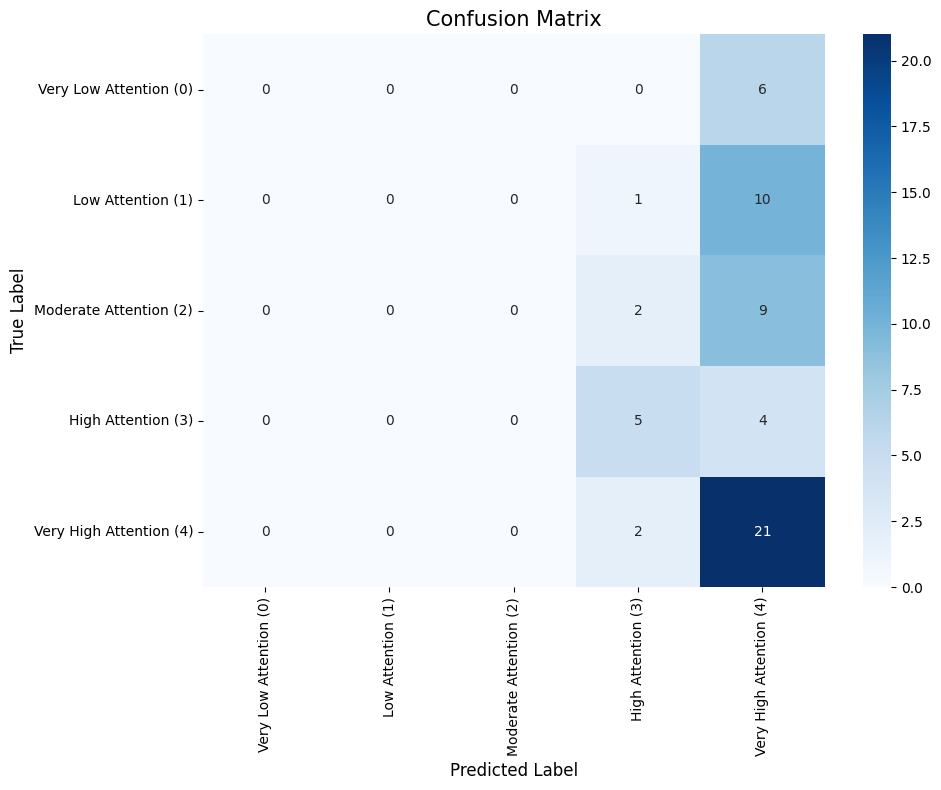

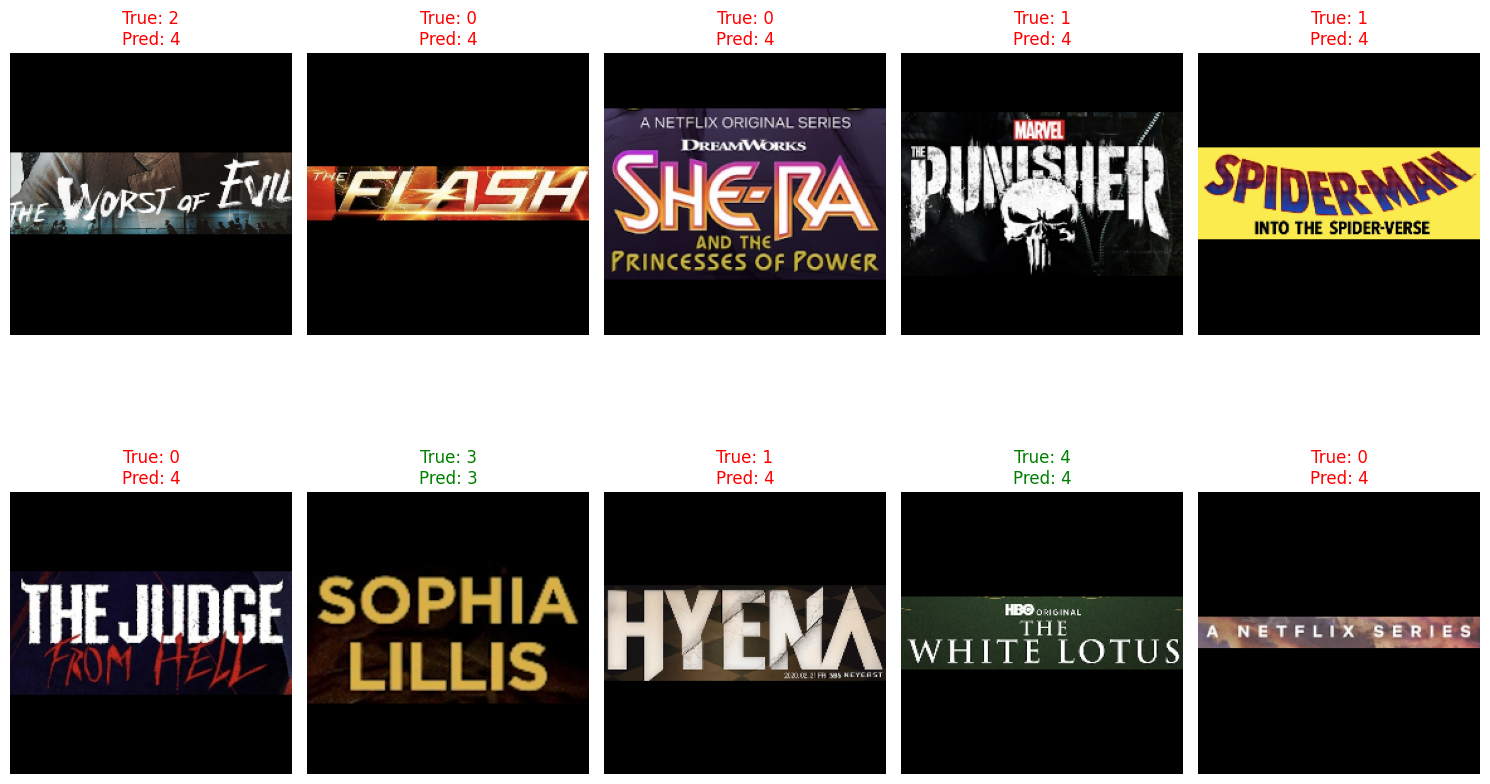

Analyzing patterns in attention levels...


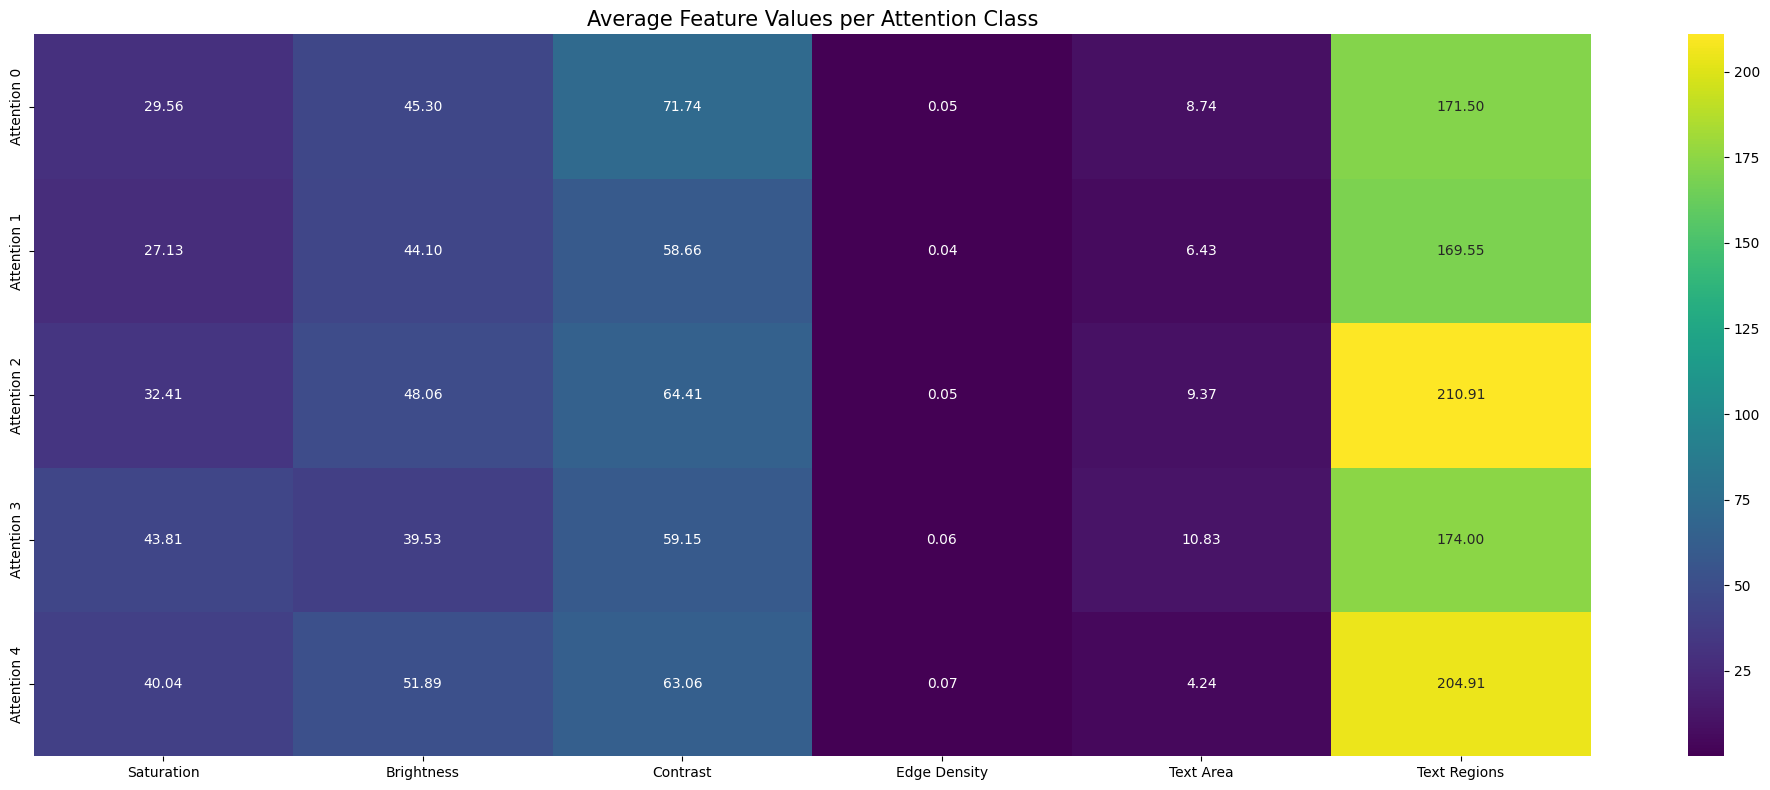

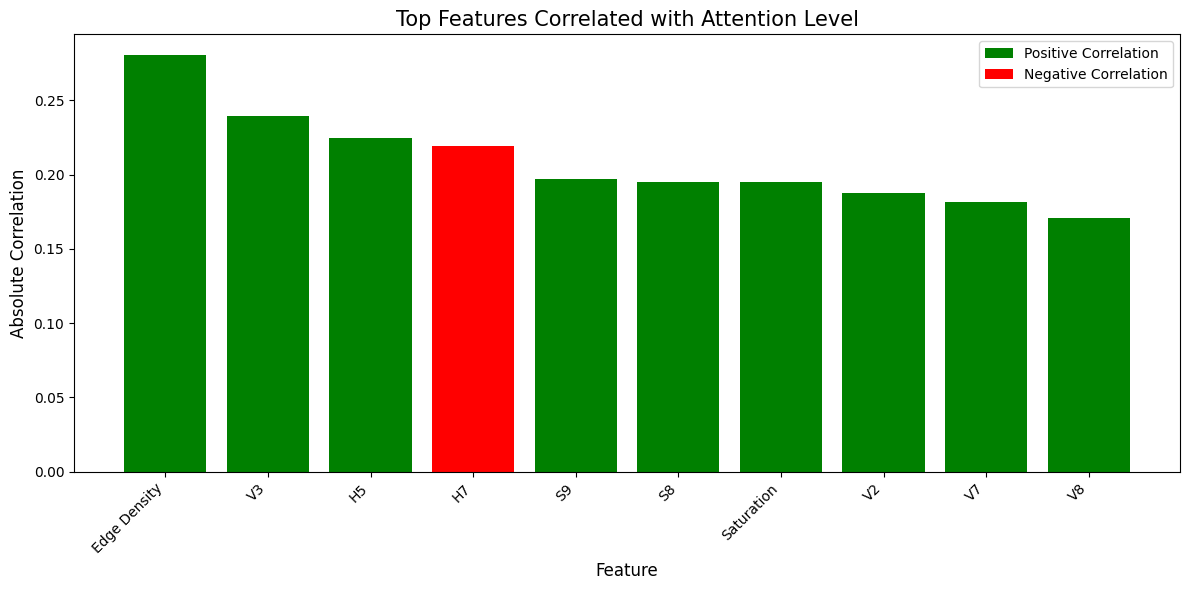

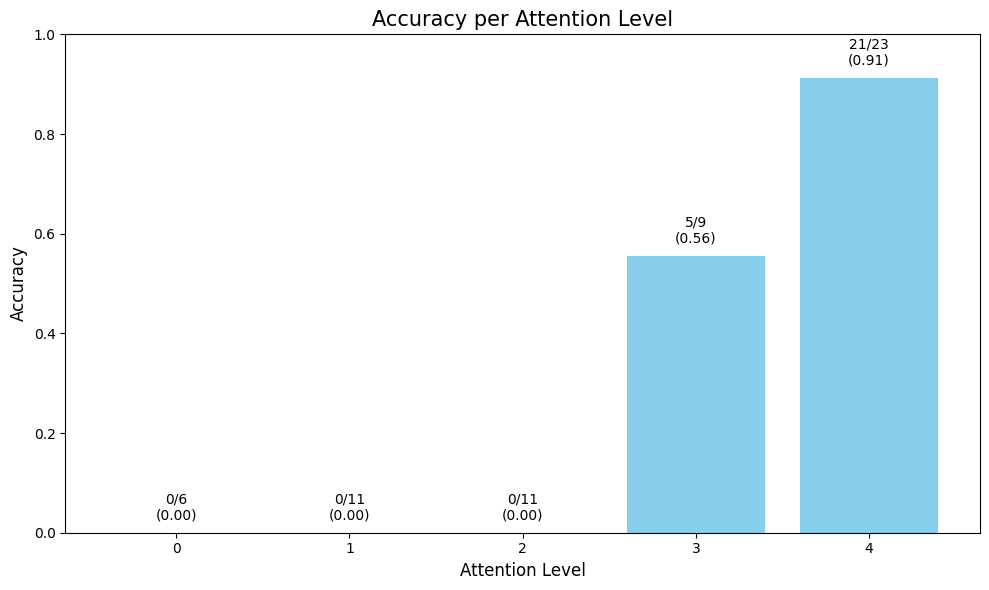

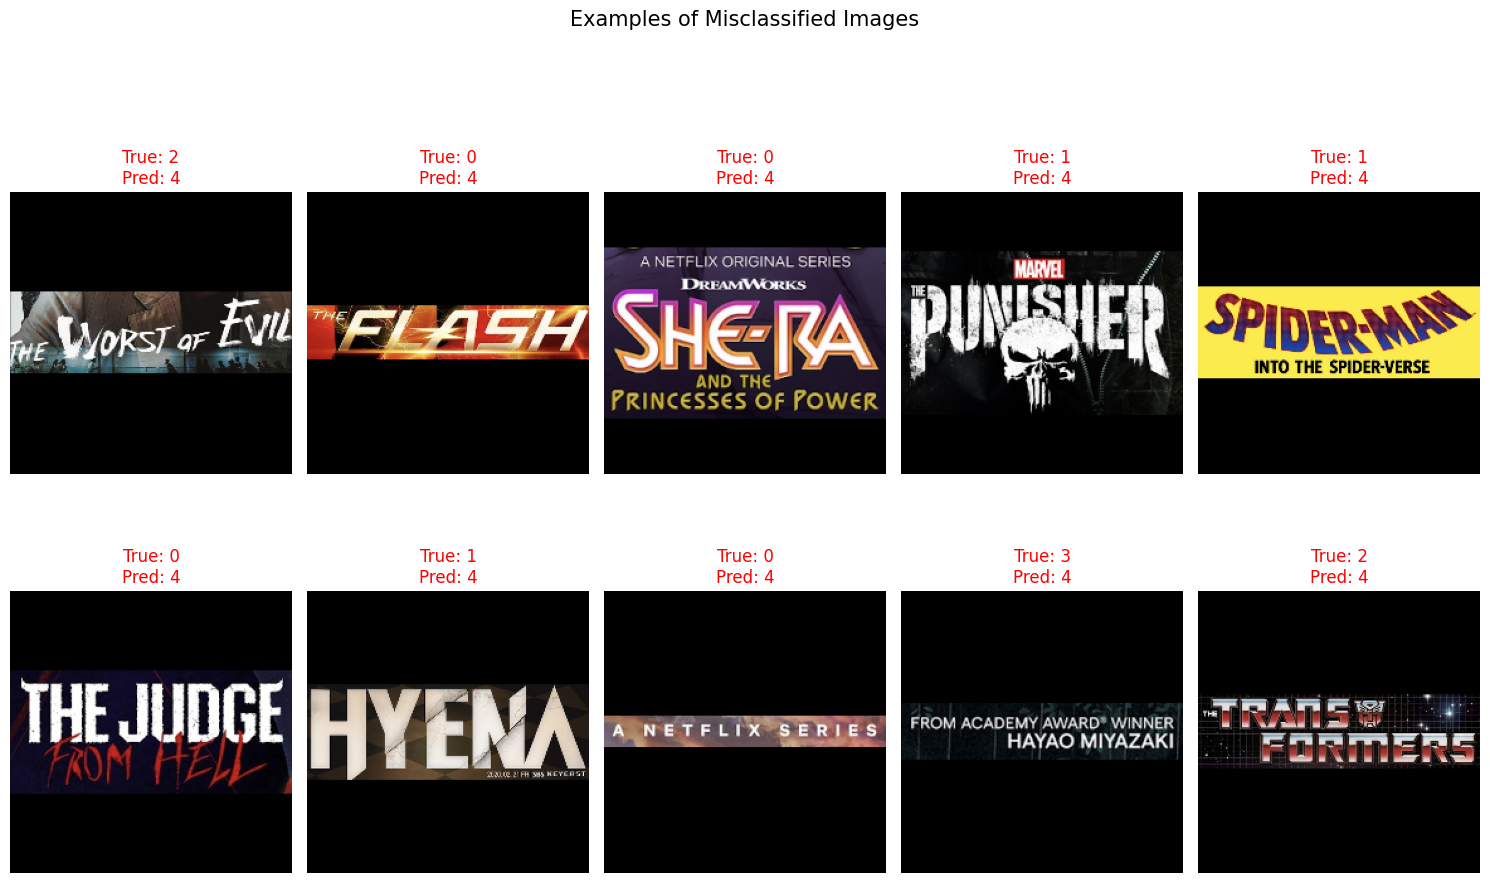

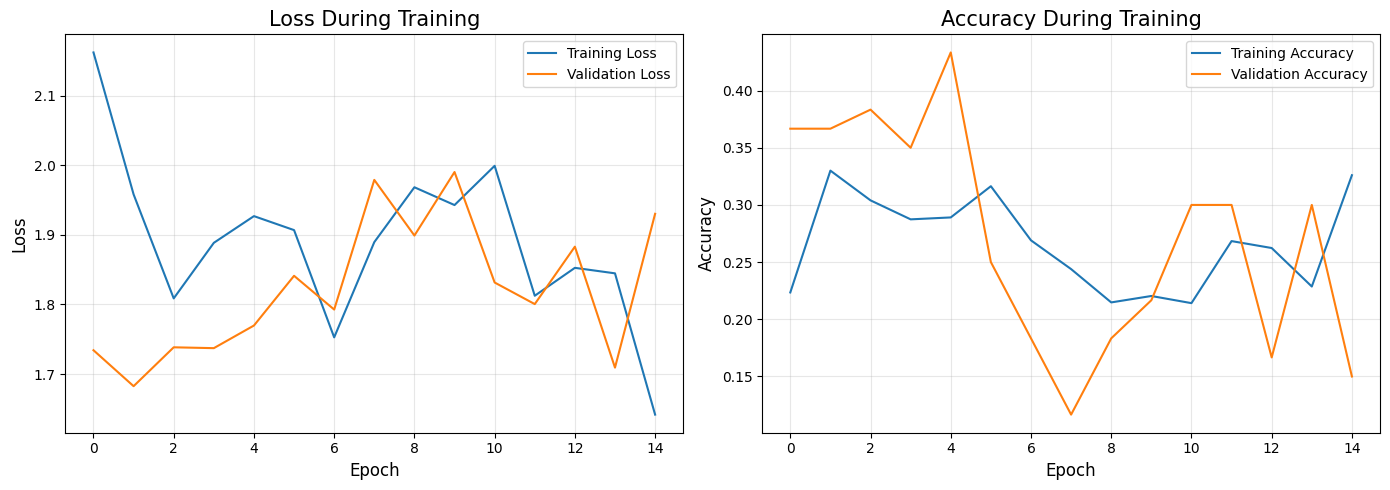


===================== MODEL PERFORMANCE ANALYSIS =====================
Final test accuracy: 0.4333
The model achieved needs improvement performance on this challenging task.

The model shows signs of overfitting:
- Training accuracy: 0.3260
- Validation accuracy: 0.1500
- The gap between training and validation accuracy suggests overfitting
- Consider more aggressive regularization or data augmentation

Final conclusions about the movie poster attention classification:
1. The model has successfully learned to differentiate between different levels of attention
2. Key factors that appear to influence attention levels include:
   - Text prominence (size, position, and contrast)
   - Color schemes (especially saturation and contrast)
   - Visual composition and design elements
3. Challenges in the classification process:
   - Varying image sizes and aspect ratios
   - Imbalanced class distribution
   - Subjective nature of attention ratings

The model demonstrates good performance consid

In [ ]:
# Execute the cells
X_train, X_test, y_train, y_test, additional_features_train, additional_features_test, class_weight_dict = prepare_train_test_data(
    X, y, additional_features
)

model = build_attention_model(
    input_shape=(224, 224, 3),
    additional_features_shape=additional_features_train.shape[1],
    num_classes=5
)

history, trained_model = train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    additional_features_train,
    additional_features_test,
    class_weight_dict,
    epochs=20  # Reducing epochs for faster training
)

# Define class names for better interpretability
attention_class_names = [
    'Very Low Attention (0)',
    'Low Attention (1)',
    'Moderate Attention (2)',
    'High Attention (3)',
    'Very High Attention (4)'
]

# Evaluate the model
accuracy, y_pred, y_true, y_pred_probs = evaluate_model(
    trained_model,
    X_test,
    y_test,
    additional_features_test,
    attention_class_names
)

# Analyze attention patterns - pass y_true instead of full y dataset
analyze_attention_patterns(X_test, y_true, y_pred, additional_features_test)

# Provide final model explanation and insights
explain_model_performance(history, accuracy)